## L1 - Detailed Metrics and Cross-validation

The techniques presented in here should provide enough validation when launching a machine learning model in beta. Anything less than that is just not enough to be sure that a model is indeed good or bad.

### Classification example

In [1]:
from sklearn.metrics import classification_report, roc_auc_score, log_loss, confusion_matrix

In [2]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.datasets import load_breast_cancer

from sklearn.linear_model import SGDClassifier

import numpy as np

np.random.seed(41)

So, cross-validation is good, we know this, but keeping in mind that we also need to stratify our splits, so that these will have the same distribution of targets as the full dataset is also important.

Let's first establish a baseline without stratification.

In [3]:
X, y = load_breast_cancer(return_X_y=True)
kfold = KFold()

metrics = {"classification_report": [], "roc_auc_score": [], "log_loss": [], "confusion_matrix": []}

for train_split, test_split in kfold.split(X, y):
    sgd = SGDClassifier(loss="log")
    sgd.fit(X[train_split], y[train_split])
    pred_proba = sgd.predict_proba(X[test_split]) # this one is needed for log_loss
    pred = sgd.predict(X[test_split])

    metrics["classification_report"].append(classification_report(y[test_split], pred))
    metrics["confusion_matrix"].append(confusion_matrix(y[test_split], pred))
    metrics["roc_auc_score"].append(roc_auc_score(y[test_split], pred))
    metrics["log_loss"].append(log_loss(y[test_split], pred_proba))
    
    print("Accuracy on the split is", sgd.score(X[test_split], y[test_split]))


Accuracy on the split is 0.8859649122807017
Accuracy on the split is 0.9122807017543859
Accuracy on the split is 0.7982456140350878
Accuracy on the split is 0.8245614035087719
Accuracy on the split is 0.8495575221238938


In [4]:
for k, vs in metrics.items():
    print(k)
    [print(f"On split {idx}:\n", v) for idx, v in enumerate(vs)]
    print("\n\n")

classification_report
On split 0:
               precision    recall  f1-score   support

           0       0.98      0.82      0.90        68
           1       0.79      0.98      0.87        46

    accuracy                           0.89       114
   macro avg       0.89      0.90      0.88       114
weighted avg       0.90      0.89      0.89       114

On split 1:
               precision    recall  f1-score   support

           0       0.98      0.82      0.89        49
           1       0.88      0.98      0.93        65

    accuracy                           0.91       114
   macro avg       0.93      0.90      0.91       114
weighted avg       0.92      0.91      0.91       114

On split 2:
               precision    recall  f1-score   support

           0       0.63      1.00      0.78        40
           1       1.00      0.69      0.82        74

    accuracy                           0.80       114
   macro avg       0.82      0.84      0.80       114
weighted avg 

Now, with stratification.

In [5]:
X, y = load_breast_cancer(return_X_y=True)
skfold = StratifiedKFold()

metrics = {"classification_report": [], "roc_auc_score": [], "log_loss": [], "confusion_matrix": []}

for train_split, test_split in skfold.split(X, y):
    sgd = SGDClassifier(loss="log")
    sgd.fit(X[train_split], y[train_split])
    pred_proba = sgd.predict_proba(X[test_split])
    pred = sgd.predict(X[test_split])
    metrics["classification_report"].append(classification_report(y[test_split], pred))
    metrics["confusion_matrix"].append(confusion_matrix(y[test_split], pred))
    metrics["roc_auc_score"].append(roc_auc_score(y[test_split], pred))
    metrics["log_loss"].append(log_loss(y[test_split], pred_proba))
    
    print("Accuracy on the split is", sgd.score(X[test_split], y[test_split]))

Accuracy on the split is 0.8596491228070176
Accuracy on the split is 0.9298245614035088
Accuracy on the split is 0.8771929824561403
Accuracy on the split is 0.8859649122807017
Accuracy on the split is 0.8141592920353983


In [6]:
for k, vs in metrics.items():
    print(k)
    [print(f"On split {idx}:\n", v) for idx, v in enumerate(vs)]
    print("\n\n")

classification_report
On split 0:
               precision    recall  f1-score   support

           0       0.97      0.65      0.78        43
           1       0.82      0.99      0.90        71

    accuracy                           0.86       114
   macro avg       0.89      0.82      0.84       114
weighted avg       0.88      0.86      0.85       114

On split 1:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91        43
           1       0.94      0.94      0.94        71

    accuracy                           0.93       114
   macro avg       0.93      0.93      0.93       114
weighted avg       0.93      0.93      0.93       114

On split 2:
               precision    recall  f1-score   support

           0       0.76      0.98      0.85        42
           1       0.98      0.82      0.89        72

    accuracy                           0.88       114
   macro avg       0.87      0.90      0.87       114
weighted avg 

Notice how when not doing statification we have splits with different proportions of the positive and negative class, and how when doing stratification we have a stable number of positive and negative examples.

Another important mechanism that you can employ to properly validate your models is to do ROC and Precision-Recall curves. To better understand the behaviour of your models. 

Find [here](https://www.displayr.com/what-is-a-roc-curve-how-to-interpret-it/) how to interpret a ROC curve and [here](https://medium.com/@douglaspsteen/precision-recall-curves-d32e5b290248) the precision-recall curve. Basically the points (not seen here) on these curves are obtained by measuring different predictive performance characteristics of a model given different thresholds.

In [7]:
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve

import matplotlib.pyplot as plt

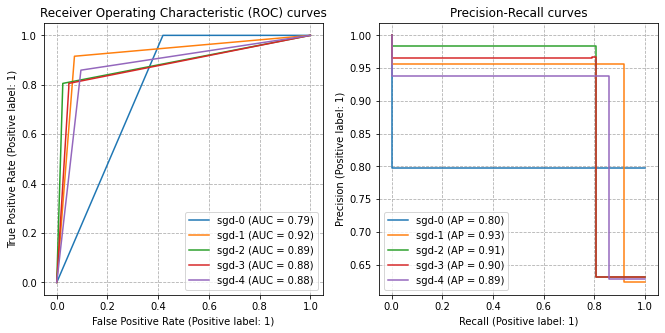

In [10]:
fig, [ax_roc, ax_pr] = plt.subplots(1, 2, figsize=(11, 5))

for split_no, (train_split, test_split) in enumerate(skfold.split(X, y)):
    sgd = SGDClassifier(loss="log")
    sgd.fit(X[train_split], y[train_split])

    plot_roc_curve(sgd, X[test_split], y[test_split],
                    ax=ax_roc, name=f"sgd-{split_no}", drop_intermediate=False)
    plot_precision_recall_curve(sgd, X[test_split], y[test_split],
                                 ax=ax_pr, name=f"sgd-{split_no}")


ax_roc.set_title('Receiver Operating Characteristic (ROC) curves')
ax_pr.set_title('Precision-Recall curves')

ax_roc.grid(linestyle='--')
ax_pr.grid(linestyle='--')

plt.legend()
plt.show()

Maybe plot Precision-Recall curves one by one.

### Regression example

In [9]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

In [10]:
# we can't trivially stratify the dataset when faced with a regression problem
from sklearn.model_selection import KFold
from sklearn.datasets import fetch_openml

from sklearn.linear_model import SGDRegressor

In [11]:
# Source: https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html

def load_mtpl2(n_samples=100000):
    """Fetch the French Motor Third-Party Liability Claims dataset.

    Parameters
    ----------
    n_samples: int, default=100000
      number of samples to select (for faster run time). Full dataset has
      678013 samples.
    """
    # freMTPL2freq dataset from https://www.openml.org/d/41214
    df_freq = fetch_openml(data_id=41214, as_frame=True)['data']
    df_freq['IDpol'] = df_freq['IDpol'].astype(int)
    df_freq.set_index('IDpol', inplace=True)

    # freMTPL2sev dataset from https://www.openml.org/d/41215
    df_sev = fetch_openml(data_id=41215, as_frame=True)['data']

    # sum ClaimAmount over identical IDs
    df_sev = df_sev.groupby('IDpol').sum()

    df = df_freq.join(df_sev, how="left")
    df["ClaimAmount"].fillna(0, inplace=True)

    # unquote string fields
    for column_name in df.columns[df.dtypes.values == object]:
        df[column_name] = df[column_name].str.strip("'")
    return df.iloc[:n_samples]

In [12]:
# Source: https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html

df = load_mtpl2(n_samples=60000)

# Note: filter out claims with zero amount, as the severity model
# requires strictly positive target values.
df.loc[(df["ClaimAmount"] == 0) & (df["ClaimNb"] >= 1), "ClaimNb"] = 0

# Correct for unreasonable observations (that might be data error)
# and a few exceptionally large claim amounts
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)
df["ClaimAmount"] = df["ClaimAmount"].clip(upper=200000)

In [13]:
from functools import partial

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer


log_scale_transformer = make_pipeline(
    FunctionTransformer(func=np.log),
    StandardScaler()
)

column_trans = ColumnTransformer(
    [
        ("binned_numeric", KBinsDiscretizer(n_bins=10),
            ["VehAge", "DrivAge"]),
        ("onehot_categorical", OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"]),
        ("passthrough_numeric", "passthrough",
            ["BonusMalus"]),
        ("log_scaled_numeric", log_scale_transformer,
            ["Density"]),
    ],
    remainder="drop",
)

# Insurances companies are interested in modeling the Pure Premium, that is
# the expected total claim amount per unit of exposure for each policyholder
# in their portfolio:
df["PurePremium"] = df["ClaimAmount"] / df["Exposure"]

# This can be indirectly approximated by a 2-step modeling: the product of the
# Frequency times the average claim amount per claim:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]
df["AvgClaimAmount"] = df["ClaimAmount"] / np.fmax(df["ClaimNb"], 1)

In [15]:
# Based on: https://medium.com/analytics-vidhya/probabilistic-model-selection-with-aic-bic-in-python-f8471d6add32

def adj_r2(y, y_hat, X):
    r2 = r2_score(y, y_hat)
    n, p = X.shape[0], X.shape[1]
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)


def aic(y, y_hat, X):
    return 2 * X.shape[1] - 2 * np.log(mean_squared_error(y, y_hat))


def aic_c(y, y_hat, X):
    k, n = X.shape[1], X.shape[0]
    return aic(y, y_hat, X) + (2 * k * k + 2 * k) / (n - k - 1)


def bic(y, y_hat, X):
    return np.log(X.shape[0]) * X.shape[1] - 2 * np.log(mean_squared_error(y, y_hat))

Notice that adjusted R2, AIC, AICc and BIC all depend on the number of parameters a model has. That's why it is possible for example to use these metrics INSTEAD of cross-validation for model selection, but be careful.

In [16]:
X = column_trans.fit_transform(df)
y = df.ClaimAmount.values

skfold = KFold()
metrics = {"rmse": [], "mape": [], "r2": []}

for train_split, test_split in skfold.split(X, y):
    sgd = SGDRegressor(max_iter=10_000)
    sgd.fit(X[train_split], y[train_split])
    pred = sgd.predict(X[test_split])
    
    # AIC, AICc, BIC and Adjusted R2, all estimate the goodness of fit,
    # that's why we use predictions on the train set, not test set
    pred_on_train = sgd.predict(X[train_split])
    print("Adjusted R2:", adj_r2(y[train_split], pred_on_train, X[train_split]))
    print("AIC:", aic(y[train_split], pred_on_train, X[train_split]))
    print("AICc", aic_c(y[train_split], pred_on_train, X[train_split]))
    print("BIC", bic(y[train_split], pred_on_train, X[train_split]))
    print()
    
    metrics["rmse"].append(mean_squared_error(y[test_split], pred, squared=False))
    metrics["mape"].append(mean_absolute_percentage_error(y[test_split], pred))
    metrics["r2"].append(r2_score(y[test_split], pred))

/home/alexburlacu/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


Adjusted R2: -1062925310.8096064
AIC: 76.21847104869822
AICc 76.45008294228194
BIC 725.8612365005603

Adjusted R2: -1.2925990516288022
AIC: 116.14662564686324
AICc 116.37823754044696
BIC 765.7893910987253

Adjusted R2: -0.9928061469270035
AIC: 116.619157122474
AICc 116.85076901605771
BIC 766.261922574336

Adjusted R2: -0.5663174787031247
AIC: 116.83168488650026
AICc 117.06329678008397
BIC 766.4744503383623

Adjusted R2: -0.5282604622969094
AIC: 117.61718286397705
AICc 117.84879475756077
BIC 767.2599483158391



In [17]:
for k, vs in metrics.items():
    print(k)
    [print(f"On split {idx}:\n", v) for idx, v in enumerate(vs)]
    print("\n\n")

rmse
On split 0:
 204937409.49844682
On split 1:
 2663.5761784887286
On split 2:
 2900.114912147473
On split 3:
 1965.2084117921945
On split 4:
 2761.6155641855976



mape
On split 0:
 2.113855920255991e+23
On split 1:
 1.3290720094497613e+18
On split 2:
 3.522465899151058e+18
On split 3:
 2.3902503250823316e+18
On split 4:
 2.8230034485972736e+18



r2
On split 0:
 -18251984313.547718
On split 1:
 -1.9083644050159378
On split 2:
 -1.2358442661751465
On split 3:
 -1.060986162726345
On split 4:
 -0.1746719834453534





See also:
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
- https://danilzherebtsov.medium.com/continuous-data-stratification-c121fc91964b
- https://scikit-learn.org/stable/auto_examples/exercises/plot_cv_diabetes.html
- https://stackoverflow.com/questions/54945196/sklearn-stratified-k-fold-cv-with-linear-model-like-elasticnetcv
